<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            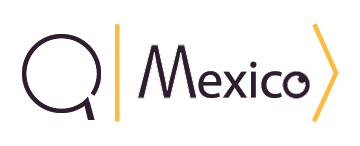
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;"> Matriz de calibración y mitigación de errores de medición </div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Bruno Ramírez</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Circuitos de calibración](#secc1)
   1. [Cómo construir circuitos de calibración en Qiskit](#secc1.1)
3. [La matriz de calibración](#secc2)
   1. [Obteniendo la matriz de calibración en Qiskit](#secc2.1)
   2. [Interpretando la matriz de calibración](#secc2.2)
4. [Mitigando errores de medición con matriz de calibración](#secc3)
6. [Referencias](#refs)


<a id="intro"></a>
# Introducción

Por lo general la medición del estado de un qubit es la última parte de un algoritmo cuántico. Como todo en cómputo cuántico, las mediciones no están excentas de errores. En el caso de los qubits superconductores las mediciones hechas a través de [absorción de fotones](https://es.wikipedia.org/wiki/Absorci%C3%B3n_%28%C3%B3ptica%29) y [cavidades resonantes](https://es.wikipedia.org/wiki/Cavidad_resonante) están sujetas a errores del equipo, fallas en detectores, etc. Estos errores provocan que al usuario de una computadora cuántica se le muestre un resultado en el estado $\ket{1}$ cuando el sistema físico en realidad estaba en el estado $\ket{0}$ o viceversa. Por fortuna, los errores de medición son fáciles de corregir. 

Comencemos por mostrar cómo se ven los errores de medición. Para esto mostramos un contraste entre un circuito simple ejecutado en un simulador sin ruido (caso ideal) y en uno con un modelo de ruido pre-definido. Alternativamente se puede ejecutar en uno de los dispositivos reales de IBM. 


In [1]:
# Herramientas de Python auxiliares a Qiskit
import numpy as np
import matplotlib.pyplot as plt

# Herramientas de Qiskit necesarias para crear y ejecutar circuitos cuánticos en simulador y dispositivos
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, IBMQ  #para importar
from qiskit.providers.aer import noise
from qiskit.providers.ibmq import least_busy

from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

# Herramientas de Qiskit necesarias para crear el modelo de ruido a utilizar
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

# Herramientas de Qiskit Ignis que utilizaremos
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter)

#Por si deseamos utilizar los dispositivos de IBM
#IBMQ.load_account()

In [2]:
# Definimos nuestro modelo de ruido a utilizar durante todo este notebook
def get_noise(p):
    error_meas = pauli_error([('X',p), ('I', 1 - p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")   
    return noise_model

# Creamos una instancia de nuestro modelo de ruido
noise_model = get_noise(0.2) # Este número definirá el grado de ruido simulado, mientras más grande más ruido

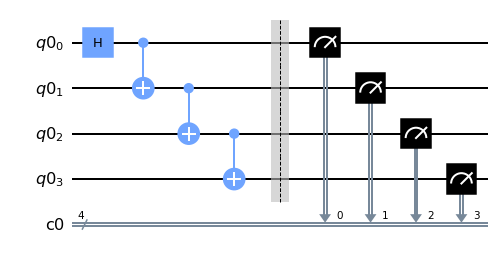

In [3]:
#Creamos un circuito de prueba que ejecutaremos en un simulador o en un dispositivo real
qreg = QuantumRegister(4)
creg = ClassicalRegister(4)
qc = QuantumCircuit(qreg,creg)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.barrier()
qc.measure(range(0,4),range(0,4))
 
#Imprimimos nuestro circuito de prueba, debería devolver el estado entrelazado de cuatro qubits     
qc.draw(output = "mpl")

In [4]:
# Definimos cual será nuestro simulador
simulator = Aer.get_backend("qasm_simulator")

# Ejecución en simulador sin ruido
sim_counts = execute(qc, backend = simulator, shots = 1024, optimization_level = 0).result().get_counts()

# Ejecución en simulador con ruido
noise_counts = execute(qc, backend = simulator, shots = 1024, optimization_level = 0, 
                       noise_model = noise_model).result().get_counts()

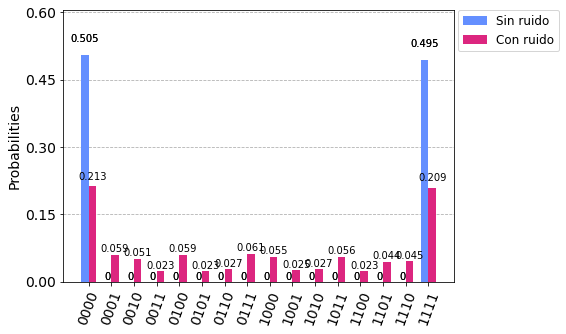

In [5]:
# Comparación de cuentas en los dispositivos con y sin ruido
plot_histogram([sim_counts, noise_counts], legend = ["Sin ruido","Con ruido"])

Aquí vemos que el circuito ejecutado en el simulador con ruido devuelve valores distintos de los esperados en algunas ocasiones. Gran parte de estos errores suelen atribuirse a errores de medición. Este comportamiento es característico del dispositivo modelo de ruido generado. Podemos correr el circuito en un dispositivo real para ver cual es su comportamiento característico. 

A lo largo de este Notebook nos centraremos en hacer mitigación de errores con modelos de ruido creados por nosotros.

<a id="secc1"></a>
# Circuitos de calibración

Como todo en la vida, la corrección de algo comienza por entender que está pasando. Esto es lo que nos perimte hacer la función `complete_meas_cal()` y los circuitos cuánticos que se nos devuelven. Veamos cómo hacer la corrección de errores de medición en nuestro circuito de ejemplo, donde tenemos $n= 4$ qubits.


### Función:  `complete_meas_cal(qubit_list=None, qr=None, cr=None, circlabel='')`:
> __¿Qué hace?__: Para un número determinado de qubits ($n=4$ en nuestro caso), esta función nos devuelve $2^n$ circuitos que generan cada uno de los elementos de la base como resultado.
    
> __¿Qué argumentos toma?__ 
- ``qubit_list (Optional[List[int]])``: La lista de qubits sobre la cual se hará la correción de errores. Si no se da un valor de `qubit_list` pero si de `qr` se asume que se usará todo el registro cuántico.
- ``qr (Union[int, List[QuantumRegister], None])``: Nombre o tamaño del registro cuántico a utilizar.
- ``cr (Union[int, List[ClassicalRegister], None])``: Nombre o tamaño del registro clásico a utilizar.
- ``circlabel (str)``: Una cadena de caracteres que se agregará al nombre de cada circuito para identificarlos.
    
> __¿Qué devuelve?__: Devuelve una tupla con dos listas. La primera de las listas está compuesta de $2^n$ objetos `QuantumCircuit` que generan cada uno de los estados de la base, mientras que la segunda lista está compuesta de `str`, cadenas que identifican a cada circuito de calibración.


<a id="secc1.1"></a>
## Cómo construir circuitos de calibración en Qiskit

Adelante vemos como utilizar Qiskit para corregir errores de calibración que afecten a __todos__ nuestros cuatro qubits. Más adelante veremos el caso en el que sólo algunos qubits son afectados.

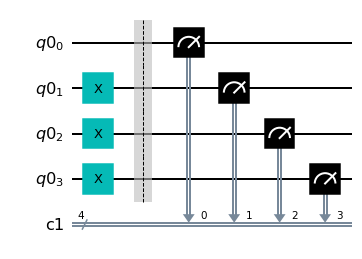

In [6]:
#####################
# complete_meas_cal #
#####################

# Creamos nuestros 2^4 = 16 circuitos de calibración, corregimos errores en todos los qubits

calcircs, calcircs_label = complete_meas_cal(qubit_list=[0,1,2,3], qr=qreg, cr=None, circlabel='calcirc_meas')

# Imprimimos el circuito número 15, que generará como salida el estado |1110>
# Cambia el valor entre corchetes para ver otros circuitos
calcircs[14].draw(output = "mpl")

<a id="secc2"></a>
# La Matriz de calibración

Construir los circuitos de calibración no nos permite entender por completo el comportamiento ruidoso de nuestro dispositivo. Para eso hay que ejecutar cada uno de los circuitos y ver qué sucedió con ellos, y así tendremos información del comportamiento. La clase __CompleteMeasFitter__ de Qiskit nos perimte hacer esto último.

### Clase:  `CompleteMeasFitter(results, state_labels, qubit_list=None, circlabel='')`:
> __¿Qué hace?__: Una vez que se ejecutaron los circuitos de calibración en un dispositivo ruidoso, esta clase permite tomar los resultados y generar un objeto que contiene una matriz de calibración y un filtro de calibración. Este objeto es útil para conocer completamente y posteriormente corregir los errores.
    
> __¿Qué parámetros de construcción tiene?__ 
- ``results (Union[Result, List[Result]])``: Los resultados que se obtienen al correr los circuitos de calibración.
- ``state_labels (List[str]) ``: Lista de los identificadores de cada uno de los circuitos de calibración, `calcircs_label`.
- ``qubit_list (Optional[List[int]]) ``: Lista de qubits para los cuales se generará el objeto, dependiendo de cuántos qubits sean dependerá la dimensión de la matriz de calibración.
- ``circlabel (str)``: Una cadena de caracteres que se agregará al nombre de cada circuito para identificarlos.
    
> __¿Qué construye?__: Construye un objeto que contiene dos atributos principales. Inicializa una matriz de calibración a partir de los resultados que se le entregaron, `matcal = measfitter.cal_matrix`, y a partir de esta devuelve un filtro aplicable a los resultados para corregir los errores `filtro = measfitter.filter`. Este filtro se aplica a los resultados mediante un método de la clase, `res_corregido = filtro.apply(results)`.


<a id="secc2.1"></a>
## Obteniendo la matriz de calibración en Qiskit

Demostración de cómo cambia la apariencia de una matriz de calibración antes y después de agregar un modelo de ruido, posiblemente importe el modelo de ruido de algún dispositivo real.


In [7]:
# Ejecutando cada uno de los circuitos de calibración en un dispositivo con modelo de ruido
cal_results = execute(calcircs, backend = simulator, shots = 1024, noise_model = noise_model).result()

######################
# CompleteMeasFitter #
######################


# Creando la matriz de calibración a partir de los resultados.
meas_fitter = CompleteMeasFitter(cal_results, calcircs_label, circlabel='calcirc_meas')


In [8]:
#Si se quiere visualizar la matriz de calibración con valores numéricos, un poco grande e intimidante

#print(meas_fitter.cal_matrix)


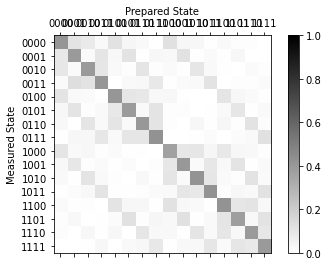

In [9]:
# Representación gráfica de la matriz de calibración
meas_fitter.plot_calibration()

<a id="secc2.2"></a>
## Interpretando el contenido de la matriz de calibración

La matriz de calibración es fácil de interpretar una vez que vemos las etiquetas en los ejes. Para cada uno de los estados preparados (etiqueta X), existe la posibilidad de que midamos otro de los 15 estados restantes. Esto se representa en la escala de gris que acompaña a cada uno de las marcas en el eje Y. Un tono blanco indica que es imposible medir algun estado final, mientras que un tono negro indica que es más probable medir dicho estado. Lo ideal es que la matriz de calibración se vea como una "matriz blanca con un bloques negros en la diagonal". Esto significaría que para cada uno de los estados preparados, siempre mediremos dicho estado y no alguno de los demás.

Además de lo anterior, podemos acceder a uno de los métodos de la clase `CompleteMeasFitter` para tener una medida numérica de que tan fiables son nuestras mediciones. Esto se determina con la [_fidelidad_](https://www.fisicalab.com/apartado/medidas-precision#fidelidad), la capacidad de realizar mediciones y obtener el valor correcto en múltiples ocasiones bajo las mismas condiciones. Esta medida se calcula con la traza normalizada de la matriz de calibración, mientras más cercano a 1, mejor.


In [10]:
# Uso del método readout_fidelity()
print("La fidelidad de medición es:", meas_fitter.readout_fidelity())

La fidelidad de medición es: 0.4034423828125


<a id="secc3"></a>
# Mitigando errores de medición con matriz de calibración

La mitigación de errores consiste en utilizar la información almacenada en la matriz de calibración para corregir los errores que genera nuestro modelo de ruido. Esto se hace a través del atributo `filter` de la clase `meas_filter`. El principio matemático detrás de esta correción, o filtrado es aquel de una inversión matricial. Si consideramos el experimento de 4 qubits al inicio de este notebook y asumimos que la relación entre el diccionario de conteos con ruido ($C_{R}$) y sin ruido ($C_{S}$) está dada por una matriz, esta matriz deberá de ser de $16 \times 16$, similar a nuestra matriz de calibración.

$$ C_{R} = M_{calib} C_{S} $$

Podemos recuperar el diccionario de conteos sin ruido simplemente aplicando

$$ C_{S} = M_{calib}^{-1} C_{R} $$

A este método se le conoce como mitigación de errores con pseudo-inversa. La mitigación de errores en Qiskit utilizando el atributo `filter` hace un uso más sofisticado de esta inversión. Veámosla en acción.


Regresemos al experimento que se creó al principio del notebook en el que vimos el efecto del ruido sobre los conteos en nuestro circuito de 16 qubits. Adelante corregiremos las mediciones.

In [11]:
# Creamos un filtro que corrige a partir de la información en nuestra matriz de calibración
meas_filter = meas_fitter.filter

# Generamos nuevamente las mediciones ruidosas
noise_results = execute(qc, backend = simulator, shots = 1024, optimization_level = 0, noise_model = noise_model).result()
noise_counts = noise_results.get_counts()

# A los resultados ruidosos le aplicamos el filtro, obtenemos los conteos con el filtro aplicado

mitigated_results = meas_filter.apply(noise_results, method = "least_squares")
mitigated_counts = mitigated_results.get_counts()


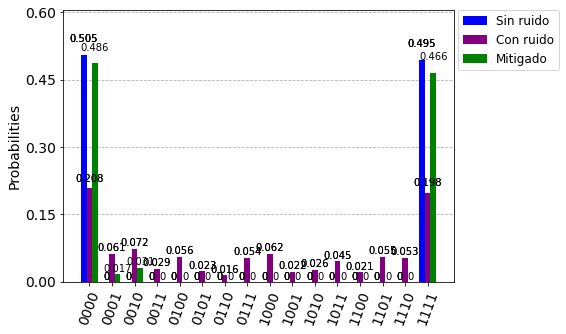

In [12]:
# Comparación de cuentas: Ideal, con ruido, con ruido, mitigado
plot_histogram([sim_counts, noise_counts, mitigated_counts], legend = ["Sin ruido","Con ruido", "Mitigado"], 
               color=['blue', 'purple','green'])

Como podemos observar, __¡la mitigación de errores funciona bien!__ Casi recuperamos un perfil de cuentas igual a aquel que se produce cuando ejecutamos el circuito sin ruido alguno.

La efectividad de nuestra mitigación está limitada por el grado de ruido. En ocasiones, si el ruido es muy severo, la mitigación resulta ser poco efectiva. Prueba utilizando un parámetro mayor para el modelo de ruido creado . 

<a id="refs"></a>
# Referencias
***
- [1] Qiskit Development Team. Tutorial: Measurement Error Mitigation. Consultado en https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html#Tensored-mitigation

- [2] Qiskit Development Team. Mitigation (qiskit.ignis.mitigation). Consultado en https://qiskit.org/documentation/apidoc/mitigation.html

- [3] The Qiskit Team. Measurement Error Mitigation. Consultado en https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html


<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="03_Relajacion_y_Decoherencia.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: 03_Relajación_y_Decoherencia
            </a>
            </div>
        </td>
        <td>
            <div style="text-align: right;">
            <a href="05_Mitigacion_Tensorial.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: 05_Mitigación_Tensorial >>
            </a>
            </div>
        </td>
    </tr>
</table>